# Imports

In [16]:
import pandas as pd
import numpy as np
import scipy
from sklearn import decomposition
import surprise
import implicit
from implicit.als import AlternatingLeastSquares
import pickle
import matplotlib.pyplot as plt

# DataFrame de test

In [3]:
df = pd.read_csv("news-portal-user-interactions-by-globocom\\clicks_sample.csv",
                 sep=",")

In [4]:
df.columns

Index(['user_id', 'session_id', 'session_start', 'session_size',
       'click_article_id', 'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
      dtype='object')

In [5]:
df.drop(columns=['session_id', 'session_start', 'session_size',
       'click_timestamp', 'click_environment',
       'click_deviceGroup', 'click_os', 'click_country', 'click_region',
       'click_referrer_type'],
       inplace = True)

In [6]:
df.head()

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


# Test Surprise

In [30]:
df.insert(2, "rating", 1)

In [31]:
df.head()

,user_id,click_article_id,rating
0,0,157541,1
1,0,68866,1
2,1,235840,1
3,1,96663,1
4,2,119592,1


In [32]:
reader = surprise.Reader(rating_scale=(0,1), line_format="user item rating")
data = surprise.Dataset.load_from_df(df, reader)

In [33]:
algo = surprise.SVDpp()

In [34]:
surprise.model_selection.cross_validate(algo,
                                        data,
                                        measures=["RMSE", "MAE"],
                                        cv = 5,
                                        verbose = True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0240  0.0268  0.0269  0.0313  0.0335  0.0285  0.0034  
MAE (testset)     0.0111  0.0148  0.0129  0.0159  0.0172  0.0144  0.0022  
Fit time          0.03    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.01    0.01    0.00    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.02401615, 0.02676723, 0.02693778, 0.03133376, 0.03348199]),
 'test_mae': array([0.01105984, 0.01481783, 0.01292733, 0.01592696, 0.01719456]),
 'fit_time': (0.02899789810180664,
  0.019001007080078125,
  0.019516468048095703,
  0.020998716354370117,
  0.02000117301940918),
 'test_time': (0.009001731872558594,
  0.005009174346923828,
  0.0049974918365478516,
  0.005004167556762695,
  0.0069980621337890625)}

# Test Implicit

In [103]:
presdf = pd.DataFrame()

In [104]:
sdf = presdf.astype(dtype=pd.SparseDtype("int", 0))

In [105]:
df

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592
...,...,...
1878,705,119592
1879,705,284847
1880,706,108854
1881,706,96663


In [106]:
sdf.index = df.user_id.unique()

In [107]:
columns = df.click_article_id.unique()
for col in columns:
    sdf.insert(loc = 0, column = col, value = 0)
sdfdefrag = sdf.copy()
sdfdefrag

C:\Users\educh\AppData\Local\Temp\ipykernel_41776\3686462367.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sdf.insert(loc = 0, column = col, value = 0)


,162245,83472,84094,355863,260988,273355,299837,66326,141945,210448,...,44488,48915,236294,236065,30970,119592,96663,235840,68866,157541
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
for clk in df.index:
    sdfdefrag.loc[df.iloc[clk]["user_id"], df.iloc[clk]["click_article_id"]] +=1

In [130]:
sdfdefrag

,162245,83472,84094,355863,260988,273355,299837,66326,141945,210448,...,44488,48915,236294,236065,30970,119592,96663,235840,68866,157541
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
703,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
705,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [135]:
sdfdefrag.loc[666].values*sdfdefrag.loc[666].index

Index([     0,      0,      0,      0,      0,      0,      0,      0,      0,
            0,
       ...
            0,      0,      0,      0,      0, 119592,      0,      0,      0,
            0],
      dtype='int64', length=323)

In [119]:
model = AlternatingLeastSquares(factors=64, regularization = 0.05, alpha = 2.0)
model.fit(scipy.sparse.csr_matrix(sdfdefrag))

100%|██████████| 15/15 [00:00<00:00, 16.13it/s]


In [118]:
user_id = 666

In [144]:
ids, scores = model.recommend(
    userid = user_id, 
    user_items= scipy.sparse.csr_matrix(sdfdefrag.loc[666].values*sdfdefrag.loc[666].index), 
    N=5, 
    filter_already_liked_items=True)

In [145]:
ids

array([206, 173,  86, 172, 102])

In [146]:
scores

array([0.17767802, 0.15735859, 0.14997429, 0.14442581, 0.07396455],
      dtype=float32)

# Test Content based

In [7]:
with open("news-portal-user-interactions-by-globocom\\articles_embeddings.pickle", 'rb') as pkl:
    embedding = pickle.load(pkl)

In [8]:
embedding.shape

(364047, 250)

In [9]:
embedding

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [19]:
pca = decomposition.PCA(n_components = 50)
pca.fit(embedding)

PCA(n_components=50)

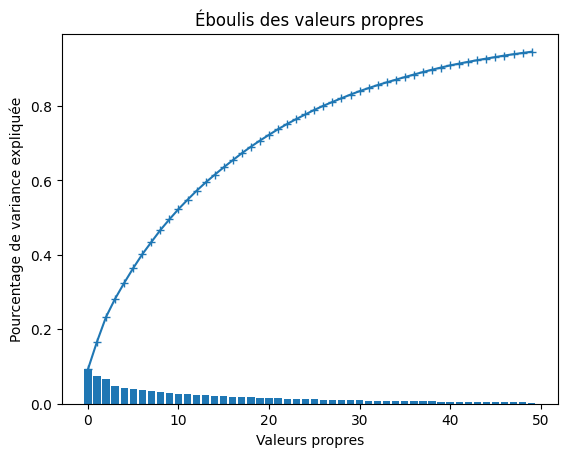

In [20]:
# Graphe de l'éboulis des valeurs propres
plt.bar(range(50), pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_.cumsum(), marker= '+')
plt.title("Éboulis des valeurs propres")
plt.xlabel('Valeurs propres')
plt.ylabel('Pourcentage de variance expliquée')
plt.show()